# ДЗ-1. Выкачивание постов и комментариев сообщества                                                            вконтакте

*Ася Симонян, БКЛ-152* (сообщество https://vk.com/vk_moscow)

Предустановки

In [39]:
import requests
import json
import re
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') 

from collections import Counter

In [26]:
def vk_api(method, **kwargs):
    api_request = 'https://api.vk.com/method/'+method + '?'
    api_request += '&'.join(['{}={}'.format(key, kwargs[key]) for key in kwargs])
    return json.loads(requests.get(api_request).text)

In [27]:
group_info = vk_api('groups.getById', group_id='vk_moscow', v='5.63')
group_id = group_info['response'][0]['id']

Выкачиваем посты

In [28]:
posts = []
item_count = 120
result = vk_api('wall.get', owner_id=-group_id, v='5.63', count=100)
posts += result["response"]["items"]
while len(posts) < item_count:
    result = vk_api('wall.get', owner_id=-group_id, v='5.63', count=100, offset=len(posts))
    posts += result['response']["items"]

Выкачиваем информацию по комментариям к посту

In [29]:
def comm_get(post, n):
    comm_info = []
    result = vk_api('wall.getComments', owner_id=-group_id, post_id=post, v='5.63', count=100)
    comm_info += result["response"]['items']
    if n > 100:
        while len(comm_info) < n:
            result = vk_api('wall.getComments', owner_id=-group_id, post_id=post, v='5.63', count=100, offset=len(comm_info))
            comm_info += result['response']["items"]
    return comm_info

Записываем информацию в файл. Перед текстом поста будет пометка <\post_text>,
перед текстом комментария - <\comment_text>

In [30]:
def write_file(item, item_type):
    with open('InteresnayaMoskva.txt', 'a', encoding='UTF-8') as f:
        f.write(item_type + item)

Считаем количество слов

In [31]:
def len_count(item):
    text = item['text']
    reg = re.compile('[^а-яёА-ЯЁ0-9a-zA-Z]+', flags=re.U | re.DOTALL)
    text = re.sub(reg, ' ', text)
    words = text.split(' ')
    item_len = len(words)
    return item_len

Добудем доступную нам информацию о комментаторе (посты в этой группы никогда не публикуются от именни пользователя, так что об авторе поста собирать информацию не получится)

In [32]:
gr1_data = {}
gr2_data = []

In [33]:
import datetime
def user_info(u_id, dt):
    result = vk_api('users.get', user_ids=u_id, fields='bdate,city', v='5.63')
    user = result['response'][0]
    if 'bdate' in user and len(user['bdate']) >= 9:
        a = datetime.datetime.fromtimestamp(dt).strftime('%Y-%m-%d %H:%M:%S')
        if a[5] == '0':
            comm_date = a[8:10] + '.' + a[6:7] +'.' + a[:4]
        else:
            comm_date = a[8:10] + '.' + a[5:7] +'.' + a[:4]
        comm = comm_date.split('.')
        birth = user['bdate'].split('.')
        #print('comm', comm[1:], 'birth', birth[1:])
        if int(comm[1]) < int(birth[1]):
            age = int(comm[2]) - int(birth[2]) - 1
        else:
            age = int(comm[2]) - int(birth[2])
    else:
        age = ''
    if 'city' in user:
        city = user['city']['title']
    else:
        city = ''
    return age, city

In [34]:
i = 1
for post in posts:
    try:
        postlen = len_count(post)
        comm_n = post['comments']['count']
        post_id = post['id']
        comment_info = comm_get(post_id, comm_n)
        write_file(post['text'], '\n<post_text>\n')
        if postlen not in gr1_data:
            gr1_data[postlen] = []
        for item in comment_info:
            commlen = len_count(item)
            if item['text'] != '':
                write_file(item['text'], '\n<comment_text>\n')
            age, city = user_info(item['from_id'], item['date'])
            gr1_data[postlen].append(commlen)
            gr2_data.append([commlen, age, city])
    except IndexError:
        continue
    print(i, end=' ')
    i += 1

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 

Построим первый график

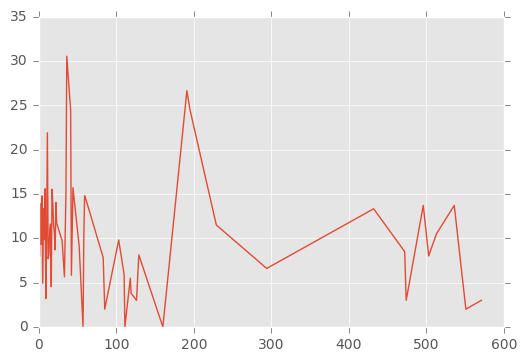

In [35]:
%matplotlib inline
p_lnths = sorted(list(gr1_data))
c_lnths = []
for el in p_lnths:
    if len(gr1_data[el]) != 0:
        c_lnths.append(sum(gr1_data[el])/len(gr1_data[el]))
    else:
        c_lnths.append(0)
plt.plot(p_lnths, c_lnths)

Построем второй график

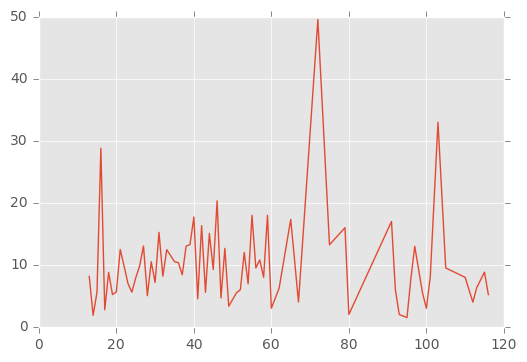

In [36]:
%matplotlib inline
d = {}
for el in gr2_data:
    #print(el)
    age = el[1]
    if age not in d:
        d[age] = []
    d[age].append(el[0])
d.pop('')
ages = sorted(list(d))
ca_lnths = []
for years in ages:
    ca_lnths.append(sum(d[years])/len(d[years]))
plt.plot(ages, ca_lnths)

Построим третий график

([<matplotlib.axis.XTick at 0x1e2c34d1940>,
 <a list of 432 Text xticklabel objects>)

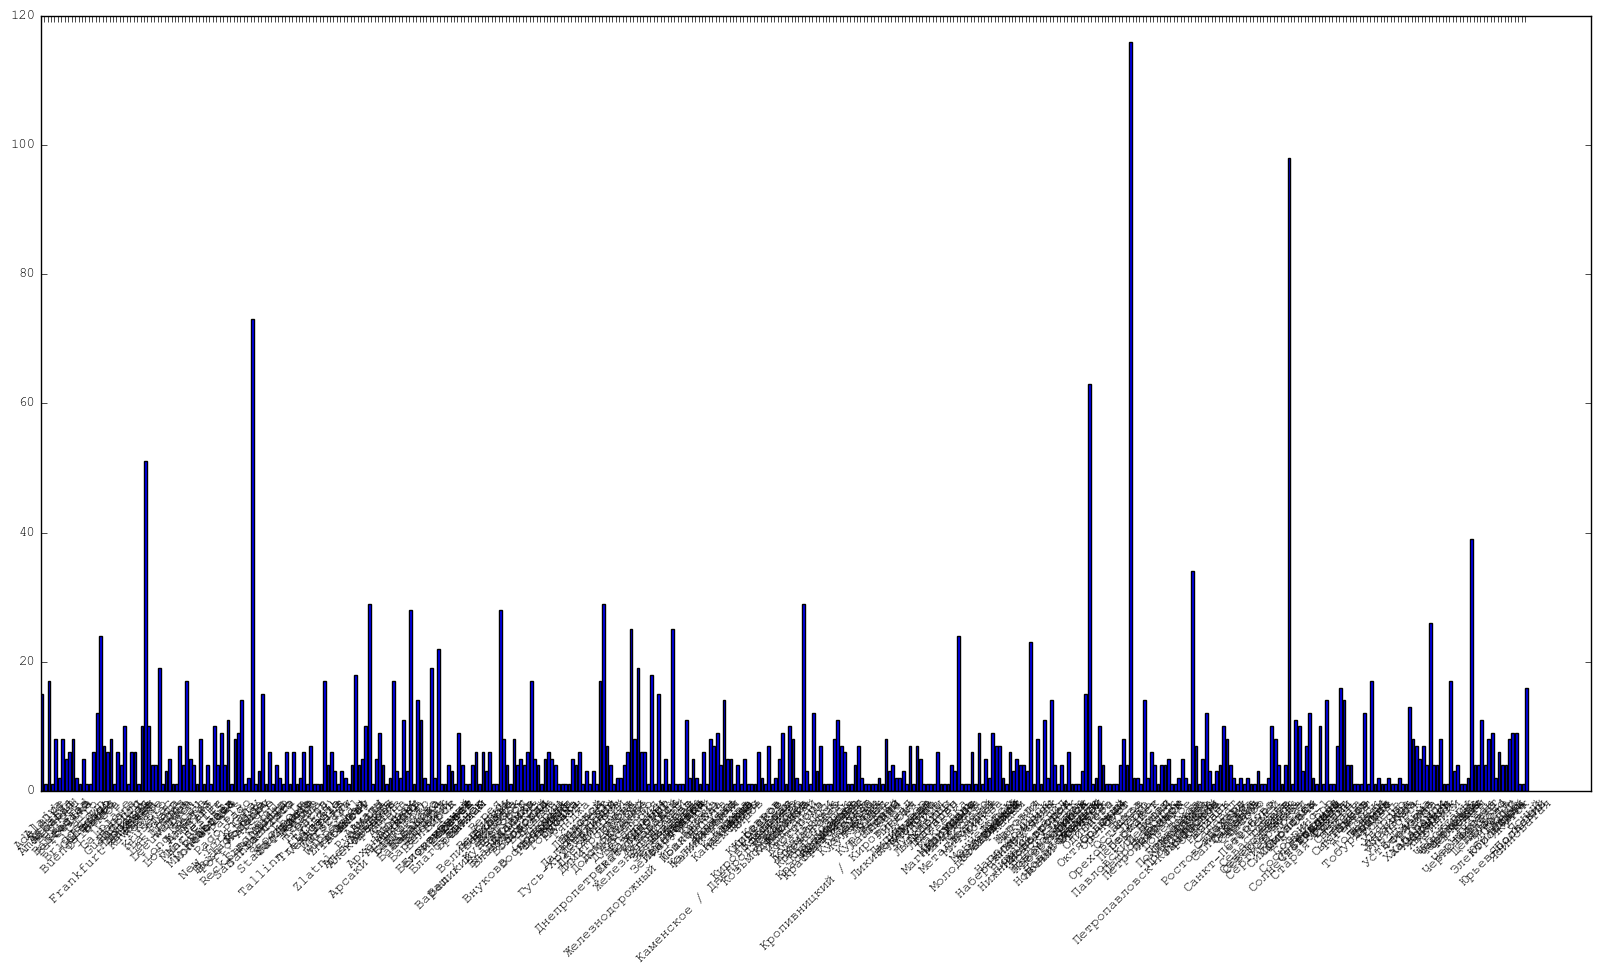

In [44]:
%matplotlib inline
d1 = {}
for el in gr2_data:
    if el[2] not in d:
        d1[el[2]] = []
    d1[el[2]].append(el[0])
d1.pop('')
cities = sorted(list(d1))
ca_lnths = []
for city in cities:
    ca_lnths.append(sum(d1[city])/len(d1[city]))
plt.figure(figsize=(20,10))
plt.bar(range(len(cities)), ca_lnths)
plt.xticks(range(len(cities)), cities, rotation=45)

In [43]:
import matplotlib
from matplotlib import rc 
matplotlib.rcdefaults() # сброс настроек 

font = {'family': 'Courier New', 
'weight': 'normal'} 
rc('font', **font)